In [22]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np


# Function to read rewards or losses from a file
def read_data(file_path: str) -> list:
    with open(file_path, "r") as file:
        data = [float(line.strip()) for line in file.readlines()]
    return data


# Function to calculate the number of steps for a given score
def score_to_steps_v3(total_score: float) -> int:
    adjusted_score = total_score - 0.003 + 1e-9
    k = int(adjusted_score // 1.095)
    r = int((adjusted_score - k * 1.095) // 0.003)
    N = k * 32 + r + 1
    return N


# Function to smooth data using a convolution
def smooth_data(data, window_size=200):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, mode="same")


# Function to add vertical jitter
def add_jitter(data, jitter_amount=0.2):
    return data + np.random.uniform(-jitter_amount, jitter_amount, size=len(data))


# Mock play_game function to simulate gameplay and return random distributions
def play_game():
    batch_size = 1
    action_space = 4
    n_atoms = 31
    distribution = np.random.rand(batch_size, action_space, n_atoms)
    distribution /= distribution.sum(
        axis=2, keepdims=True
    )  # Normalize to make it a valid probability distribution
    return distribution[0]  # Since batch size is 1, return the first element


# Read the rewards and losses data from the files
rewards_path = "rewards.txt"
losses_path = "losses.txt"

rewards = read_data(rewards_path)
losses = read_data(losses_path)

# Calculate the steps for each reward using the refined function
steps_list = [score_to_steps_v3(reward) for reward in rewards]

# Total number of steps
total_steps = sum(steps_list)

# Total duration of the animation in seconds
total_duration = 5

# Frame rate (frames per second)
frame_rate = 30

# Total number of frames
total_frames = total_duration * frame_rate

# Generate the time steps for rewards and losses
reward_times = np.cumsum(steps_list)
loss_times = np.arange(0, len(losses) * 3, 3)

# Smooth the rewards and losses data
smoothed_rewards = smooth_data(rewards, 500)
smoothed_losses = smooth_data(losses, 10000)

# Number of rewards and losses per frame
rewards_per_frame = len(reward_times) / total_frames
losses_per_frame = len(loss_times) / total_frames

# Prepare the figure with a 2x2 grid
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 12))
ax1.set_xlim(0, len(rewards))
ax1.set_ylim(0, max(max(rewards), max(smoothed_rewards)))
ax2.set_xlim(0, total_steps)
ax2.set_yscale("log")
ax2.set_ylim(0.0005, 0.4)

(reward_dots,) = ax1.plot([], [], "go", alpha=0.2, markersize=1, label="Rewards")
(loss_dots,) = ax2.plot([], [], "ro", alpha=0.2, markersize=1, label="Losses")
(smoothed_reward_line,) = ax1.plot([], [], "g-", label="Smoothed Rewards")
(smoothed_loss_line,) = ax2.plot([], [], "r-", label="Smoothed Losses")
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Reward")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Loss")
ax1.legend(loc="upper left")
ax2.legend()

rewards = add_jitter(rewards)

# Initialize the bar plots for game frames and distributions
bar_plot_game = ax3.imshow(np.random.rand(10, 10), cmap="gray")
bars = [ax4.bar(range(31), np.zeros(31), alpha=0.7) for _ in range(4)]
ax4.set_ylim(
    0,
    1,
)
ax3.set_title("Game Frame")
ax4.set_title("Action Distributions")
ax4.set_xlabel("Support")
ax4.set_ylabel("Probability")


# Initialize the plot
def init():
    reward_dots.set_data([], [])
    loss_dots.set_data([], [])
    smoothed_reward_line.set_data([], [])
    smoothed_loss_line.set_data([], [])
    bar_plot_game.set_data(np.random.rand(10, 10))
    for bar in bars:
        for rect in bar:
            rect.set_height(0)
    return (
        reward_dots,
        loss_dots,
        smoothed_reward_line,
        smoothed_loss_line,
        bar_plot_game,
        *bars[0],
        *bars[1],
    )


# Animation function
def animate(i):
    # Calculate the current indices
    reward_index = int(i * rewards_per_frame)
    loss_index = int(i * losses_per_frame)

    # Select the data to show
    rewards_to_show = reward_times[:reward_index]
    losses_to_show = loss_times[:loss_index:100]

    # Add jitter to rewards
    jittered_rewards = rewards[:reward_index]

    # Set data for scatter points
    reward_dots.set_data(range(0, len(jittered_rewards)), jittered_rewards)
    loss_dots.set_data(
        losses_to_show[: len(losses[:loss_index:100])], losses[:loss_index:100]
    )

    # Set data for smoothed lines
    if reward_index >= 200:
        smoothed_reward_line.set_data(
            range(len(smoothed_rewards[: reward_index - 199])),
            smoothed_rewards[: reward_index - 199],
        )
    if loss_index >= 200:
        smoothed_loss_line.set_data(
            loss_times[: len(smoothed_losses[: loss_index - 199])],
            smoothed_losses[: loss_index - 199],
        )

    # Generate a random game frame and distribution
    game_frame = np.random.rand(10, 10)  # Mock game frame
    distribution = play_game()

    # Update game frame plot
    bar_plot_game.set_data(game_frame)

    # Update distribution bar plots
    for action in range(4):
        for rect, height in zip(bars[action], distribution[action]):
            rect.set_height(height)

    return (
        reward_dots,
        loss_dots,
        smoothed_reward_line,
        smoothed_loss_line,
        bar_plot_game,
        *bars[0],
        *bars[1],
    )


# Create the animation
anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=total_frames,
    interval=1000 / frame_rate,
    blit=True,
)

# Save the animation
anim.save(
    "rewards_losses_animation_with_game.mp4",
    fps=frame_rate,
    extra_args=["-vcodec", "libx264"],
)

plt.close(fig)  # Close the figure to avoid displaying it in an interactive environment

In [8]:
from RAINBOW_DQN import RainbowDQN, DistributionalLoss, PrioritizedReplayBuffer
import gymnasium as gym
import torch


def play_learned_policy(
    env_name: str,
    model_path: str,
    n_atoms: int,
    v_min: float,
    v_max: float,
    gamma: float,
    lookahead: int,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    """
    Plays according to a learned policy stored in a .pth file.

    Args:
        env_name (str): The name of the gym environment.
        model_path (str): Path to the .pth file containing the learned model.
        n_atoms (int): Number of atoms in the distributional RL.
        v_min (float): Minimum value of the value distribution.
        v_max (float): Maximum value of the value distribution.
        gamma (float): Discount factor.
        lookahead (int): Lookahead steps for the prioritized replay buffer.
        device (torch.device): The device to use for computations (default: GPU if available).
    """
    # Initialize environment
    env = gym.make(env_name, render_mode="human")

    # Initialize the model
    model = RainbowDQN(n_actions=env.action_space.n, n_atoms=n_atoms).to(device)
    prioritized_replay_buffer = PrioritizedReplayBuffer(
        n_iterations=1,  # Not relevant for playing
        memory_capacity=1,  # Not relevant for playing
        alpha=0.5,  # Not relevant for playing
        beta=[0.4, 1],  # Not relevant for playing
        gamma=gamma,
        lookahead=lookahead,
    )

    state, _ = env.reset()

    model(prioritized_replay_buffer.phi(state).to(device))
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Initialize distributional loss helper
    dist_loss = DistributionalLoss(n_atoms, v_min, v_max, gamma, lookahead)

    # Reset the environment
    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        phi = prioritized_replay_buffer.phi(state)
        with torch.no_grad():
            action_probs = model(phi).cpu()
        action = dist_loss.select_action_from_predictions(action_probs).item()
        next_state, reward, done, _, _ = env.step(action)
        yield state, total_reward, action_probs
        # Yield the untransformed frame, total reward, and action probability distributions

        for _ in range(2):
            next_state, intermediate_reward, done, _, _ = env.step(0)
            reward += intermediate_reward
            if done:
                break
        state = next_state
        total_reward += reward

        # Update state and total reward


# Example usage
if __name__ == "__main__":
    env_name = "FlappyBird-v0"
    model_path = "/home/oliver/Code/RL-ALGORITHMS/RAINBOW-DQN/FlappyBird_1150000.pth"
    n_atoms = 31
    v_min = 0
    v_max = 3
    gamma = 0.99
    lookahead = 3

    for frame, total_reward, action_probs in play_learned_policy(
        env_name, model_path, n_atoms, v_min, v_max, gamma, lookahead
    ):

Total Reward: 0
Total Reward: 0.003
Total Reward: 0.006
Total Reward: 0.009000000000000001
Total Reward: 0.012
Total Reward: 0.015
Total Reward: 0.018
Total Reward: 0.020999999999999998
Total Reward: 0.023999999999999997
Total Reward: 0.026999999999999996
Total Reward: 0.029999999999999995
Total Reward: 0.032999999999999995
Total Reward: 0.036
Total Reward: 0.039
Total Reward: 0.042
Total Reward: 0.045000000000000005
Total Reward: 0.04800000000000001
Total Reward: 0.05100000000000001
Total Reward: 0.05400000000000001
Total Reward: 0.057000000000000016
Total Reward: 0.06000000000000002
Total Reward: 0.06300000000000001
Total Reward: 0.06600000000000002
Total Reward: 0.06900000000000002
Total Reward: 0.07200000000000002
Total Reward: 0.07500000000000002
Total Reward: 0.07800000000000003
Total Reward: 0.08100000000000003
Total Reward: 0.08400000000000003
Total Reward: 0.08700000000000004
Total Reward: 0.09000000000000004
Total Reward: 0.09300000000000004
Total Reward: 1.095
Total Reward: 

/tmp/ipykernel_541563/976520291.py:210: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  v_line.set_xdata(0)
/tmp/ipykernel_541563/976520291.py:210: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  v_line.set_xdata(0)
/home/oliver/Code/RL-ALGORITHMS/.venv/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


RuntimeError: The animation function must return a sequence of Artist objects.

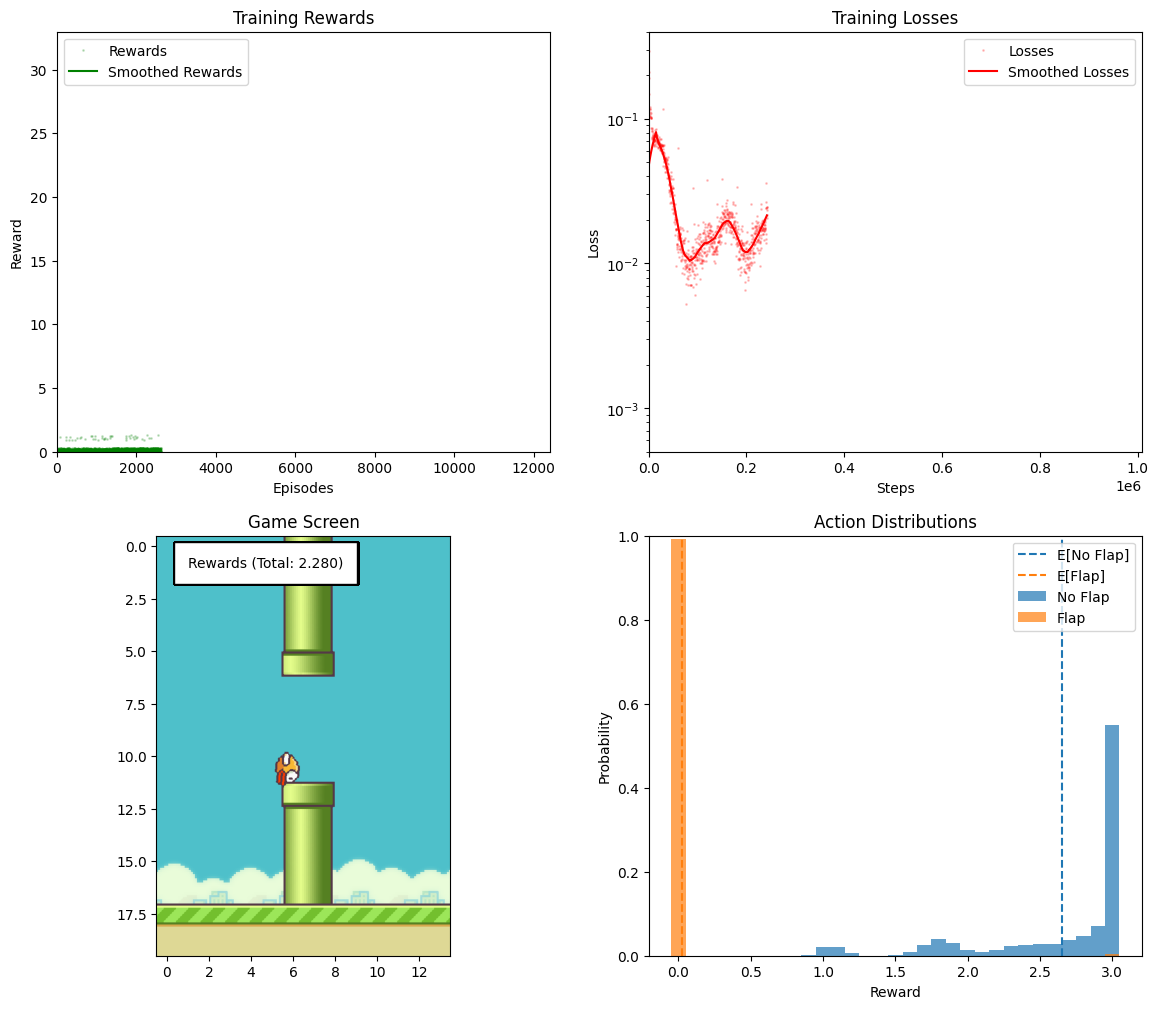

In [6]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from RAINBOW_DQN import RainbowDQN, DistributionalLoss, PrioritizedReplayBuffer
import gymnasium as gym
import torch

while True:
    try:
        # Function to read rewards or losses from a file
        def read_data(file_path: str) -> list:
            with open(file_path, "r") as file:
                data = [float(line.strip()) for line in file.readlines()]
            return data

        # Function to calculate the number of steps for a given score
        def score_to_steps_v3(total_score: float) -> int:
            adjusted_score = total_score - 0.003 + 1e-9
            k = int(adjusted_score // 1.095)
            r = int((adjusted_score - k * 1.095) // 0.003)
            N = k * 32 + r + 1
            return N

        # Function to smooth data using a convolution
        def smooth_data(data, window_size=200):
            window = np.ones(window_size) / window_size
            return np.convolve(data, window, mode="same")

        # Function to add vertical jitter
        def add_jitter(data, jitter_amount=0.2):
            return data + np.random.uniform(
                -jitter_amount, jitter_amount, size=len(data)
            )

        # Function to play learned policy and yield frames and distributions
        def play_learned_policy(
            env_name: str,
            model_path: str,
            n_atoms: int,
            v_min: float,
            v_max: float,
            gamma: float,
            lookahead: int,
            device: torch.device = torch.device(
                "cuda" if torch.cuda.is_available() else "cpu"
            ),
        ):
            # Initialize environment
            env = gym.make(env_name, render_mode="human")

            # Initialize the model
            model = RainbowDQN(n_actions=env.action_space.n, n_atoms=n_atoms).to(device)
            prioritized_replay_buffer = PrioritizedReplayBuffer(
                n_iterations=1,  # Not relevant for playing
                memory_capacity=1,  # Not relevant for playing
                alpha=0.5,  # Not relevant for playing
                beta=[0.4, 1],  # Not relevant for playing
                gamma=gamma,
                lookahead=lookahead,
            )

            state, _ = env.reset()

            model(prioritized_replay_buffer.phi(state).to(device))
            model.load_state_dict(torch.load(model_path))
            model.eval()

            # Initialize distributional loss helper
            dist_loss = DistributionalLoss(n_atoms, v_min, v_max, gamma, lookahead)

            # Reset the environment
            state, _ = env.reset()
            done = False
            total_reward = 0

            while not done:
                phi = prioritized_replay_buffer.phi(state)
                with torch.no_grad():
                    action_probs = model(phi).cpu()
                action = dist_loss.select_action_from_predictions(action_probs).item()
                next_state, reward, done, _, _ = env.step(action)
                yield state, total_reward, action_probs
                # Yield the untransformed frame, total reward, and action probability distributions

                for _ in range(2):
                    next_state, intermediate_reward, done, _, _ = env.step(0)
                    reward += intermediate_reward
                    state = next_state
                    yield state, total_reward, action_probs
                    if done:
                        break
                total_reward += reward

        # Read the rewards and losses data from the files
        rewards_path = "rewards.txt"
        losses_path = "losses.txt"

        rewards = read_data(rewards_path)
        losses = read_data(losses_path)

        # Calculate the steps for each reward using the refined function
        steps_list = [score_to_steps_v3(reward) for reward in rewards]

        # Total number of steps
        total_steps = sum(steps_list)

        # Total duration of the animation in seconds
        total_duration = 30

        # Frame rate (frames per second)
        frame_rate = 45

        # Total number of frames
        total_frames = total_duration * frame_rate

        # Generate the time steps for rewards and losses
        reward_times = np.cumsum(steps_list)
        loss_times = np.arange(0, len(losses) * 3, 3)

        # Smooth the rewards and losses data
        smoothed_rewards = smooth_data(rewards, 500)
        smoothed_losses = smooth_data(losses, 10000)

        # Number of rewards and losses per frame
        rewards_per_frame = len(reward_times) / total_frames
        losses_per_frame = len(loss_times) / total_frames

        # Create a generator for the play_learned_policy
        env_name = "FlappyBird-v0"
        model_path = (
            "/home/oliver/Code/RL-ALGORITHMS/RAINBOW-DQN/FlappyBird_1150000.pth"
        )
        n_atoms = 31
        v_min = 0
        v_max = 3
        gamma = 0.99
        lookahead = 3

        policy_generator = play_learned_policy(
            env_name, model_path, n_atoms, v_min, v_max, gamma, lookahead
        )
        dist_loss = DistributionalLoss(n_atoms, v_min, v_max, gamma, lookahead)

        # Prepare the figure with a 2x2 grid
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 12))
        ax1.set_xlim(0, len(rewards))
        ax1.set_ylim(0, max(max(rewards), max(smoothed_rewards)))
        ax2.set_xlim(0, total_steps)
        ax2.set_yscale("log")
        ax2.set_ylim(0.0005, 0.4)

        (reward_dots,) = ax1.plot(
            [], [], "go", alpha=0.2, markersize=1, label="Rewards"
        )
        (loss_dots,) = ax2.plot([], [], "ro", alpha=0.2, markersize=1, label="Losses")
        (smoothed_reward_line,) = ax1.plot([], [], "g-", label="Smoothed Rewards")
        (smoothed_loss_line,) = ax2.plot([], [], "r-", label="Smoothed Losses")
        ax1.set_title("Training Rewards")
        ax1.set_xlabel("Episodes")
        ax1.set_ylabel("Reward")
        ax2.set_title("Training Losses")
        ax2.set_xlabel("Steps")
        ax2.set_ylabel("Loss")
        ax1.legend(loc="upper left")
        ax2.legend()

        rewards = add_jitter(rewards)

        # Initialize the bar plots for game frames and distributions
        bar_plot_game = ax3.imshow(np.random.rand(20, 14), cmap="gray")
        default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

        bars = [
            ax4.bar(
                dist_loss.z,
                np.zeros(31),
                width=dist_loss.delta_z,
                alpha=0.7,
                color=default_colors[action],
                label="Flap" if action == 1 else "No Flap",
            )
            for action in range(2)
        ]
        v_lines = [
            ax4.axvline(
                x=0,
                color=default_colors[i],
                linestyle="--",
                label="E[Flap]" if i == 1 else "E[No Flap]",
            )
            for i in range(2)
        ]

        ax3.set_title("Game Screen")
        ax4.set_title("Action Distributions")
        ax4.set_xlabel("Reward")
        ax4.set_ylim(0, 1)
        ax4.set_ylabel("Probability")
        ax4.legend(loc="upper right")

        # Initialize the plot
        def init():
            reward_dots.set_data([], [])
            loss_dots.set_data([], [])
            smoothed_reward_line.set_data([], [])
            smoothed_loss_line.set_data([], [])
            bar_plot_game.set_data(np.random.rand(10, 10))
            for bar in bars:
                for rect in bar:
                    rect.set_height(0)
            for v_line in v_lines:
                v_line.set_xdata(0)
            return (
                reward_dots,
                loss_dots,
                smoothed_reward_line,
                smoothed_loss_line,
                bar_plot_game,
                *bars[0],
                *bars[1],
                *v_lines,
            )

        # Animation function
        def animate(i):
            # Calculate the current indices
            reward_index = int(i * rewards_per_frame)
            loss_index = int(i * losses_per_frame)

            # Select the data to show
            rewards_to_show = reward_times[:reward_index]
            losses_to_show = loss_times[:loss_index:100]

            # Add jitter to rewards
            jittered_rewards = rewards[:reward_index]

            # Set data for scatter points
            reward_dots.set_data(range(0, len(jittered_rewards)), jittered_rewards)
            loss_dots.set_data(
                losses_to_show[: len(losses[:loss_index:100])], losses[:loss_index:100]
            )

            # Set data for smoothed lines
            if reward_index >= 200:
                smoothed_reward_line.set_data(
                    range(len(smoothed_rewards[: reward_index - 199])),
                    smoothed_rewards[: reward_index - 199],
                )
            if loss_index >= 200:
                smoothed_loss_line.set_data(
                    loss_times[: len(smoothed_losses[: loss_index - 199])],
                    smoothed_losses[: loss_index - 199],
                )

            # Generate a random game frame and distribution

            try:
                frame, total_reward, action_probs = next(policy_generator)
            except StopIteration:
                return

            # Update game frame plot
            bar_plot_game.set_data(frame)

            # Update distribution bar plots and vertical lines
            for action in range(2):

                expected_value = np.dot(dist_loss.z, action_probs[0, :, action].numpy())
                for rect, height in zip(bars[action], action_probs[0, :, action]):
                    rect.set_height(height)
                v_lines[action].set_xdata(expected_value)

            # Update the legend with the current total reward
            # ax3.legend("Rewards (Total: {:.2f})".format(total_reward))
            ax3.text(
                1,
                1,
                "Rewards (Total: {:.3f})".format(total_reward),
                bbox={"facecolor": "white", "pad": 10},
            )

            ax2.legend()

            return (
                reward_dots,
                loss_dots,
                smoothed_reward_line,
                smoothed_loss_line,
                bar_plot_game,
                *bars[0],
                *bars[1],
                *v_lines,
            )

        # Create the animation
        anim = animation.FuncAnimation(
            fig,
            animate,
            init_func=init,
            frames=total_frames,
            interval=1000 / frame_rate,
            blit=True,
        )

        # Save the animation
        anim.save(
            "rewards_losses_animation_with_game.mp4",
            fps=frame_rate,
            extra_args=["-vcodec", "libx264"],
        )

        plt.close(
            fig
        )  # Close the figure to avoid displaying it in an interactive environment
        break
    except:
        pass